# Multi-class Classification

using the [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset, which contains 28x28 images of hands depicting the 26 letters of the english alphabet. 

In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Download the training and test sets (the test set will actually be used as a validation set):

In [2]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 88.1MB/s]


Define some globals with the path to both files you just downloaded:

In [3]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

In [4]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

 ## Parsing the dataset
 - The first line contains the column headers, so you should ignore it.

- Each successive line contains 785 comma-separated values between 0 and 255
  - The first value is the label

  - The rest are the pixel values for that picture

In [5]:
# GRADED FUNCTION: parse_data_from_input
def parse_data_from_input(filename):
  with open(filename) as training_file:
    all_lines = training_file.readlines()[1:] #remove header
    length = len(all_lines)
    labels = np.zeros(length)
    images = np.zeros((length, 28, 28))
    for idx, line in enumerate(all_lines):
      line = line.strip().split(',')
      if not line:
        continue
      #add the label
      labels[idx] = int(line[0])
      #add the image
      image = np.asarray(line[1:], dtype=np.float64)
      image = np.array_split(image, 28)
      images[idx, :, :] = image
    return images, labels

In [6]:
# Test the function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape}")
print(f"Training labels has shape: {training_labels.shape}")
print(f"Validation images has shape: {validation_images.shape}")
print(f"Validation labels has shape: {validation_labels.shape}")

Training images has shape: (27455, 28, 28)
Training labels has shape: (27455,)
Validation images has shape: (7172, 28, 28)
Validation labels has shape: (7172,)


## Visualizing the numpy arrays


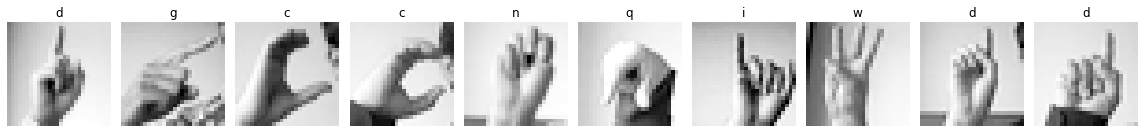

In [7]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

## Creating the generators for the CNN

- The images in this dataset come in the same resolution so don't need to set a custom `target_size` in this case. In fact, can't even do so because this time I will not be using the `flow_from_directory` method (as in previous assignments). Instead I will use the [`flow`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow) method.
- Add the "color" dimension to the numpy arrays that encode the images. These are black and white images, so this new dimension should have a size of 1 (instead of 3, which is used when dealing with colored images). Take a look at the function [`np.expand_dims`](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) for this.

In [8]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
    
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  # Instantiate the ImageDataGenerator class 
  # and set arguments to augment the images
  train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True)


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(training_images,
                                      training_labels,
                                      batch_size=32)
  
  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 
  return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


## Coding the CNN

In [10]:
def create_model():

  ### START CODE HERE       

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  from tensorflow.keras.optimizers import RMSprop

  model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(25, activation='softmax')
])
  

  model.compile(optimizer = RMSprop(lr=0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE       
  
  return model

In [11]:
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


858/858 [==============================] - 28s 22ms/step - loss: 3.0838 - accuracy: 0.0863 - val_loss: 2.7602 - val_accuracy: 0.1839
Epoch 2/15
858/858 [==============================] - 18s 22ms/step - loss: 2.7651 - accuracy: 0.1758 - val_loss: 2.2939 - val_accuracy: 0.3196
Epoch 3/15
858/858 [==============================] - 18s 21ms/step - loss: 2.5122 - accuracy: 0.2356 - val_loss: 1.9902 - val_accuracy: 0.3878
Epoch 4/15
858/858 [==============================] - 18s 21ms/step - loss: 2.3596 - accuracy: 0.2763 - val_loss: 1.8636 - val_accuracy: 0.4124
Epoch 5/15
858/858 [==============================] - 19s 22ms/step - loss: 2.2507 - accuracy: 0.3060 - val_loss: 1.7154 - val_accuracy: 0.4074
Epoch 6/15
858/858 [==============================] - 18s 21ms/step - loss: 2.1659 - accuracy: 0.3310 - val_loss: 1.5536 - val_accuracy: 0.4983
Epoch 7/15
858/858 [==============================] - 18s 21ms/step - loss: 2.0807 - accuracy: 0.3551 - val_loss: 1.5218 - val_accuracy: 0.5004
Epo

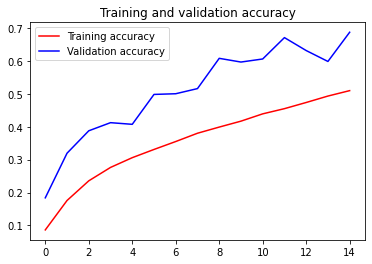

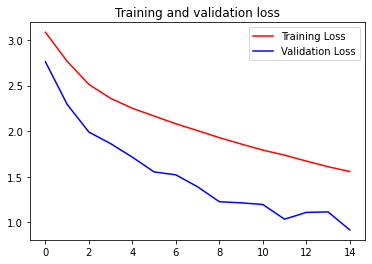

In [12]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()